In [6]:
import mempute as mp
import numpy as np
import  sys
from operator import eq
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import datetime

본 패턴체인 데이터베이스는 메모노드라는 분산 퓨전 데이터베이스로 수행되므로
데이터베이스를 먼저 아래 명령으로 d: 드라이브의 루트에 quantum 이름의 저장소를 생성하고 실행한다.
저장소 위치 및 이름은 다른 것으로 해도 된다.
> memonode -h d:\quantum -q 60 -z 3

메모노드 데이터베이스의 자세항 사항은 www.memonode.com 사이트에서 메뉴얼을 다운받아 참조.

In [32]:
def get_handle(win_exec):

    drv = mp.driver(3)

    if win_exec == 1:
        print('win')
        con = mp.connect(drv, "loopback", "", "")
    else:
        print('linux')
        con = mp.connect(drv, "localhost", "", "")

    stmt = mp.statement(con)

    return stmt

stmt = get_handle(1) #세션 오픈

win


sign 함수 학습

In [13]:
import numpy as np
import mempute as mp


from tools import create_sin, make_timeseries, split_train_test#, visualize_random_data
from tools import batch_loader, shuffle

data = create_sin()
data_x, data_y = make_timeseries(data, x_size=31, y_size=31)

data_x = np.squeeze(data_x, axis=-1)
data_y = np.squeeze(data_y, axis=-1)

train_x, test_x = split_train_test(data_x)
train_y, test_y = split_train_test(data_y)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)

np.random.seed(0)

rv = mp.direct(stmt,"execute mempute('clear', 'sign_g3 0 percep_loc 0 0 all erase 0')")
rv = mp.direct(stmt, "execute mempute('perception', 'sign_g3 locale percep_loc')")

rv = mp.direct(stmt, "execute mempute('sequence', 31, 31, 2)")

#rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.0002d}')")
#rv = mp.direct(stmt, "execute mempute('channel', 0, '{u0.0002d}')")
rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.03d}')")
rv = mp.direct(stmt, "execute mempute('channel', 0, '{u0.03d}')")

rv = mp.direct(stmt, "execute mempute('phyper', 'test_margin 1')")
rv = mp.direct(stmt, "execute mempute('phyper', 'sensitivity 4.23')")
#rv = mp.direct(stmt, "execute mempute('phyper', 'num_contraction 0')")

rv = mp.array(stmt, "execute mempute('array', 'sign_g3_input locale array_loc 1 1 1 0 0 0')")
mp.inarray(stmt, train_x, 1)

rv = mp.array(stmt, "execute mempute('array', 'sign_g3_target locale array_loc 0 1 1 0 0 0')")
mp.inarray(stmt, train_y, 1)

rv = mp.direct(stmt, "execute mempute('cognit', 'sign_g3_input', 'sign_g3_target')")

rv = mp.direct(stmt, "execute mempute('oblivion', 0)")

train_x: (5285, 31)
train_y: (5285, 31)
test_x : (1321, 31)
test_y : (1321, 31)


sign 함수 예측

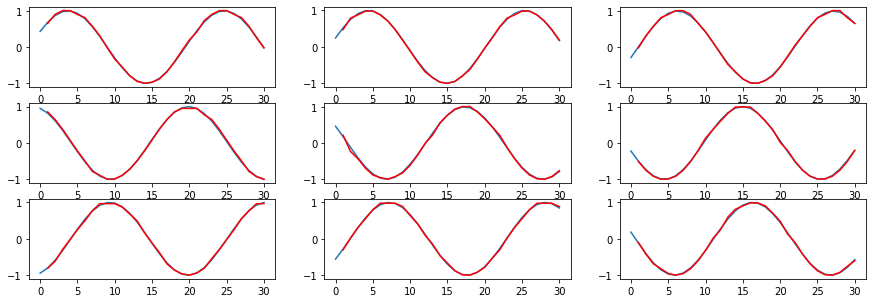

In [14]:
import pylab as plt
N = test_x.shape[0]
idices = np.random.choice(np.arange(N), size=9, replace=False)

result_pred = []
result_true = []

rv = mp.direct(stmt, "execute mempute('perception', 'sign_g3 locale percep_loc')")
rv = mp.array(stmt, "execute mempute('array', 'eval_input 1 1 0 0 0 0')")
rv = mp.array(stmt, "execute mempute('array', 'eval_output 0 1 0 0 0 0')")

for idx in idices:
    sample_x = test_x[idx:idx+1]
    sample_y = test_y[idx:idx+1]

    rv = mp.focus(stmt, "execute mempute('array', 'eval_input')")
    mp.inarray(stmt, sample_x, 1)
    y_preds = mp.mempute(stmt, "execute mempute('predict', 'eval_input', 'eval_output')")

    y_preds = y_preds.reshape(-1, 1)
    result_pred.append(y_preds)
    result_true.append(sample_y.reshape(-1, 1))

fig, plots = plt.subplots(3, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

plots = plots.reshape(-1)
for i, p in enumerate(plots):
    p.plot(result_true[i])
    p.plot(result_pred[i], color='red')

In [15]:
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

def reverse_standardization(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * org_x_np.std() + org_x_np.mean())

def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

def reshape_list(alist, init_stride, stride, width, margin, limit_row, inc):
    #width -  입력값 또는 목표값 배열의 시퀀스 갯수
    #margin - 입력값과 목표값 배열을 구성하는데 있어 두 배열의 순차가 하나의 입력배열에서 공유되는 경우이면 입력값 배열 구성일 경우 입력값 배열의 마지막으로부터 
    #           목표값 배열의 마지막까지의 입력 배열상의 시퀀스 차이 갯수, 두 배열이 각기 독립적인 입력 인덱스 체게를 갖는 입력 배열로부터 이면 0
    #limit_row - 입력 배열 제한 갯수, 0부터 시작되므로 순차가 공유되는 경우 이 로우 순차 값 하나 전 로우까지 목표값 배열로 채워지고 입력값은 이 하나전 개수에서 margin값을 제하고난 로우수까지 
    #           입력배열에 채워진다. 두 배열이 각기 독립적인 입력 인덱스 체계를 갖는 경우 각각 배열에서 이 로수 인덱스 이전까지 적재된다.
    n_input_row = len(alist)
    sub_input = alist[0]
    n_input_col = len(sub_input)

    if limit_row > 0:
        n_input_row = limit_row

    input_last = n_input_row - (margin + width)
    init_stride += ((input_last - init_stride) % stride)

    stride_origin = init_stride
    output_list = [];
    
    while stride_origin <= input_last:
        in_row = stride_origin;
        nwidth = in_row + width
        out_col = 0
        sub_output = []
        while in_row < nwidth:
            sub_input = alist[in_row]
            #print(sub_input)
            sub_output[out_col:out_col + n_input_col] = sub_input[0:]
            out_col += n_input_col
            in_row += 1
        output_list.append(sub_output);
        stride_origin += stride
    #print("----------------------------------------")
    #print(output_list)
    if inc:
        fname = "reshape_list_%d" % (inc)
        fp = open(fname, 'w') 
        print("---------------reshape list print---------------------")
        if inc < 0: inc = 1
        else: stride *= inc
        line = init_stride * inc
        n_output_row = len(output_list);
        i = 0
        while i < n_output_row:
            j = 0
            sub_output = output_list[i]
            n_output_col = len(sub_output);
            while j < n_output_col:
                s = str(sub_output[j])
                print(s + " ", end='')
                fp.write(s + " ")
                j = j + 1
            print(": %d~%d\n" % (line, line + (width -1) * inc))# 0부터 시작하므로 -1
            data = ": %d~%d\n" % (line, line + (width -1) * inc)
            fp.write(data)
            i = i + 1
            line += stride
        fp.close()

    return output_list

def list_input(stmt, fname, init_stride, stride, width, margin):
    
    f = open(fname, "r")
    str = "";
    sub = []
    while True:
        lines = f.readlines()
        if not lines :
            break

        nest = []

        for i in lines:
            row = i.replace('\n', '').replace('?', '').replace('!', '').replace('.', '').replace(';', '').replace('\'', '\\\'').split(',')
            str = row[0];
            sub = str.split()
            nest.append(sub)
        
        if stride > 0:
            nest = reshape_list(nest, init_stride, stride, width, margin, 0, -1)

        mp.inlist(stmt, nest, 0)

    f.close()

    empt = []
    mp.inlist(stmt, empt, 1)

def reshape_array(d_type, aarray, init_stride, stride, width, margin, limit_row, inc):
    #width -  입력값 또는 목표값 배열의 시퀀스 갯수
    #margin - 입력값과 목표값 배열을 구성하는데 있어 두 배열의 순차가 하나의 입력배열에서 공유되는 경우이면 입력값 배열 구성일 경우 입력값 배열의 마지막으로부터 
    #           목표값 배열의 마지막까지의 입력 배열상의 시퀀스 차이 갯수, 두 배열이 각기 독립적인 입력 인덱스 체게를 갖는 입력 배열로부터 이면 0
    #limit_row - 입력 배열 제한 갯수, 0부터 시작되므로 순차가 공유되는 경우 이 로우 순차 값 하나 전 로우까지 목표값 배열로 채워지고 입력값은 이 하나전 개수에서 margin값을 제하고난 로우수까지 
    #           입력배열에 채워진다. 두 배열이 각기 독립적인 입력 인덱스 체계를 갖는 경우 각각 배열에서 이 로수 인덱스 이전까지 적재된다.
    n_input_row = aarray.shape[0]
    n_input_col = aarray.shape[1]

    if limit_row > 0:
        n_input_row = limit_row

    n_output_col = n_input_col * width

    input_last = n_input_row - (margin + width)
    init_stride += ((input_last - init_stride) % stride)

    n_output_row = ((input_last - init_stride) / stride) +1

    output_arr = np.zeros((int(n_output_row), n_output_col), dtype = d_type)
    
    """
    out_row = 0
    stride_origin = init_stride
    while stride_origin < n_input_row:
        out_col = 0
        in_row = stride_origin
        nwidth = in_row + width
        while in_row < nwidth:
            in_col = 0
            while in_col < n_input_col:
                output_arr[out_row, out_col] = aarray[in_row, in_col]
                out_col += 1
                in_col += 1
            in_row += 1
        out_row += 1
        stride_origin += stride
    """
    out_row = 0#out_row = int(n_output_row) -1
    stride_origin = init_stride
    while stride_origin <= input_last:
        in_row = stride_origin;
        nwidth = in_row + width
        out_col = 0
        while in_row < nwidth:
            output_arr[out_row, out_col:out_col + n_input_col] = aarray[in_row,:]
            out_col += n_input_col
            in_row += 1
        out_row += 1#out_row -= 1
        stride_origin += stride
    
    if inc:
        #fname = "reshape_arr_%d" % (inc)
        #fp = open(fname, 'w') 
        #print("---------------reshape array print---------------------")
        if inc < 0: inc = 1
        else: stride *= inc
        line = init_stride * inc
        i = 0
        while i < n_output_row:
            j = 0
            while j < n_output_col:
                s = str(output_arr[i, j])
                #print(s + " ", end='')
                #fp.write(s + " ")
                j = j + 1
            #print(": %d~%d\n" % (line, line + (width -1) * inc))# 0부터 시작하므로 -1
            #data = ": %d~%d\n" % (line, line + (width -1) * inc)
            #fp.write(data)
            i = i + 1
            line += stride
        #fp.close()
    return output_arr


def array_input(d_type, stmt, fname, init_stride, stride, width, margin):
    #empt = np.zeros((0, 0), dtype = "d")
    f = open(fname, "r")
    
    while True:
        lines = f.readlines()

        if not lines :
            break

        nest = []

        for i in lines:
            row = i.split()
            nest.append(row)

        input_arr = np.array(nest)
        output_arr = reshape_array(d_type, input_arr, init_stride, stride, width, margin, 0, 0)

        mp.inarray(stmt, output_arr, 0)
    
    f.close()

    mp.inarray(stmt, None, 1)


def reshape_array_eval(d_type, aarray, apredic, width, stride, lead, margin, disp):
#apredic - aarray에서 입력 로우 시작 인덱스(에측 시작 로우 인데스 - 예측값이 width가 있는 경우 그 시작 인덱스)
#width - aarray배열에서 로우(시퀀스) 갯수, 로우단위 걸음 간격 수, 
#lead - 평가 단계에서 입력값 배열을 구성하는데 있어 학습단계에서 목표값 배열의 순차가 하나의 입력배열에서 공유되는 경우일때 입력값 배열의 마지막으로부터 
#           목표값 배열의 마지막까지의 입력 배열상의 시퀀스 차이 갯수, 두 배열이 각기 독립적인 입력 인덱스 체게를 갖는 입력 배열로부터 이면 0
#margin - 예측값 시퀀스 길이만큼 끝에서 마진을 두어 여기까지만 예측 입력을 하도록 한다. 목표값 시퀀스가 1이면 0를 설정한다.
    n_input_row = aarray.shape[0]
    n_input_col = aarray.shape[1]
    n_output_col = n_input_col * width

    gap = lead -1
    stride_origin = (apredic - (gap + width))
    n_output_row = int((n_input_row - margin - apredic) / stride)  +1

    output_arr = np.zeros((int(n_output_row), n_output_col), dtype = d_type)
    
    line = stride_origin
    out_row = 0
    while out_row < n_output_row:
        out_col = 0
        in_row = stride_origin
        while out_col < n_output_col:
            output_arr[out_row, out_col:out_col + n_input_col] = aarray[in_row, :]
            out_col += n_input_col
            in_row += 1
        stride_origin += stride
        out_row += 1
    
    if disp:
        fname = "reshape_arr_eval_%d" % (disp)
        fp = open(fname, 'w') 
        print("---------------reshape array eval print---------------------")
        i = 0
        while i < n_output_row:
            j = 0
            while j < n_output_col:
                s = str(output_arr[i, j])
                print(s + " ", end='')
                fp.write(s + " ")
                j = j + 1
            print(": %d~%d\n" % (line, line + width -1))# 0부터 시작하므로 -1
            data = ": %d~%d\n" % (line, line + width -1)
            fp.write(data)
            i = i + 1
            line += stride
        fp.close()
    return output_arr

def reshape_list_eval(alist, apredic, width, stride, lead, margin, disp):
#apredic - aarray에서 입력 로우 시작 인덱스(에측 시작 로우 인데스 - 예측값이 width가 있는 경우 그 시작 인덱스)
#width - aarray배열에서 로우(시퀀스) 갯수, 로우단위 걸음 간격 수, 
#lead - 평가 단계에서 입력값 배열을 구성하는데 있어 학습단계에서 목표값 배열의 순차가 하나의 입력배열에서 공유되는 경우일때 입력값 배열의 마지막으로부터 
#           목표값 배열의 마지막까지의 입력 배열상의 시퀀스 차이 갯수, 두 배열이 각기 독립적인 입력 인덱스 체게를 갖는 입력 배열로부터 이면 0
#margin - 예측값 시퀀스 길이만큼 끝에서 마진을 두어 여기까지만 예측 입력을 하도록 한다. 목표값 시퀀스가 1이면 0를 설정한다.
    n_input_row = len(alist)
    sub_input = alist[0]
    n_input_col = len(sub_input)
    n_output_col = n_input_col * width

    gap = lead -1
    stride_origin = (apredic - (gap + width))
    n_output_row = ((n_input_row - margin - apredic) / stride)  +1
    
    output_list = [];
    out_row = 0
    while out_row < n_output_row:
        out_col = 0
        in_row = stride_origin
        sub_output = []
        while out_col < n_output_col:
            sub_input = alist[in_row]
            #print(sub_input)
            sub_output[out_col:out_col + n_input_col] = sub_input[0:]
            out_col += n_input_col
            in_row += 1
        output_list.append(sub_output);
        stride_origin += stride
        out_row += 1

    if disp:
        print("---------------reshape array eval print---------------------")
        n_output_row = len(output_list);
        i = 0
        while i < n_output_row:
            j = 0
            sub_output = output_list[i]
            n_output_col = len(sub_output);
            while j < n_output_col:
                s = str(sub_output[j])
                print(s + " ", end='')
                j = j + 1
            print(": %d~%d\n" % (line, line + width -1))# 0부터 시작하므로 -1
            i = i + 1
            line += stride

    return output_list


def exec_batch(d_type, stmt, sor_obj, apredic, width, stride, lead, margin, disp):

    if d_type == 'n':
        list_proc = 1
        in_list = reshape_list_eval(sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = len(in_list)
    else:
        list_proc = 0
        in_arr = reshape_array_eval(d_type, sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = in_arr.shape[0]

    rv = mp.array(stmt, "execute mempute('array', 'eval_input 1 1 0 0 0 0')")

    rv = mp.array(stmt, "execute mempute('array', 'eval_output 0 1 0 0 0 0')")

    outlist = [];
    i = 0
    a = []

    rv = mp.focus(stmt, "execute mempute('array', 'eval_input')")
    while i < n_input_row:
        if list_proc == 1:
            mp.inlist(stmt, in_list[i], 1)
        else:
            a = in_arr[i, 0:]
            mp.inarray(stmt, a, 1)
        a = mp.mempute(stmt, "execute mempute('predict', 'eval_input', 'eval_output')")
        #print(a)
        outlist.append(a)
        i += 1

    return outlist #3차원 리스트 혹은 2차원 배얼을 원소로 갖는 1차원 리스트 리턴.

def exec_batch2(d_type, stmt, sor_obj, apredic, width, stride, lead, margin, disp):

    if d_type == 'n':
        list_proc = 1
        in_list = reshape_list_eval(sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = len(in_list)
    else:
        list_proc = 0
        in_arr = reshape_array_eval(d_type, sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = in_arr.shape[0]
    
    rv = mp.array(stmt, "execute mempute('array', 'eval_input 1 1 0 0 0 0')")

    rv = mp.array(stmt, "execute mempute('array', 'eval_output 0 1 0 0 0 0')")

    outlist = [];
    a = []

    rv = mp.focus(stmt, "execute mempute('array', 'eval_input')")
    if list_proc == 1:
        mp.inlist(stmt, in_list, 1)
    else:
        mp.inarray(stmt, in_arr, 1)

    a = mp.mempute(stmt, "execute mempute('predict', 'eval_input', 'eval_output')")
    #print(a)
    
    return a #2차원 리스트 혹은 2차원 배열 리턴

def exec_batch3(d_type, stmt, sor_obj, apredic, width, stride, lead, margin, disp, disc_op, disc_arg):

    if d_type == 'n':
        list_proc = 1
        in_list = reshape_list_eval(sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = len(in_list)
    else:
        list_proc = 0
        in_arr = reshape_array_eval(d_type, sor_obj, apredic, width, stride, lead, margin, disp)
        n_input_row = in_arr.shape[0]
    
    rv = mp.array(stmt, "execute mempute('array', 'eval_input 1 1 0 0 0 0')")

    if list_proc == 1:
        mp.inlist(stmt, in_list, 1)
    else:
        mp.inarray(stmt, in_arr, 1)

    rv = mp.array(stmt, "execute mempute('array', 'disc_output 0 1 0 0 0 0')")

    s = "execute mempute('discriminate', 'eval_input', {}, {}, 'disc_output')".format(disc_op, disc_arg)
    r = mp.mempute(stmt, s)
    
    return r #2차원 리스트 혹은 2차원 배열 리턴


아마존 주가 학습

In [16]:
# 데이터를 로딩한다.
stock_file_name = 'D:/c/testd/amazon/AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_input = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: %d", stock_input.shape)
print("stock_info[0]: %d", stock_input[0])

#============================ 가격형태 데이터들을 정규화한다=========================================
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_input[:,:-1]
#norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리 
norm_price = data_standardization(price)

print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_input[:,-1:]
#norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
norm_volume = data_standardization(volume)

print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

# 행은 그대로 두고 열을 우측에 붙여 합친다
stock_input = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
#====================================================================================

train_size = int(stock_input.shape[0] * 0.7)
print("tran size %f", train_size)
stock_target = stock_input[:, [-2]] # 타켓은 주식 종가이다

"""
fp = open("input_data", 'w')
print("---------------input data print---------------------")
nrow = stock_input.shape[0]
ncol = stock_input.shape[1]
i = 0
while i < nrow:
    j = 0
    data = "%d: " % i
    print(data, end='')
    fp.write(data)
    while j < ncol:
        s = str(stock_input[i, j])
        print(s + " ", end='')
        fp.write(s + " ")
        j = j + 1
    print("\n")
    fp.write("\n")
    i = i + 1
fp.close()

fp = open("target_data", 'w')
print("---------------target data print---------------------")
nrow = stock_target.shape[0]
i = 0
while i < nrow:
    data = "%d: %s\n" % (i, stock_target[i, :])
    print(data)
    fp.write(data)
    i = i + 1
fp.close()
"""
#input_data = reshape_array("f", stock_input, 0, 1, 5, 3, train_size, -1)
#target_data = reshape_array("f", stock_target, 5, 1, 3, 0, train_size, -2)
input_data = reshape_array("f", stock_input, 0, 1, 5, 3, train_size, -1)#3 = 8 - 5(width), 5-5 best
target_data = reshape_array("f", stock_target, 7, 1, 3, 0, train_size, -2)#입력의 시작으로부터 8칸 뒤에 목표값 시작되게. 입력의 끝으로부터 3 ~ 6 칸 사이를 예측
#input_data = reshape_array("f", stock_input, 0, 1, 5, 6, train_size, -1)
#target_data = reshape_array("f", stock_target, 10, 1, 3, 0, train_size, -2)#입력의 시작으로부터 11칸 뒤에 목표값 시작되게. 입력의 끝으로부터 6 ~ 9 칸 사이를 예측

rv = mp.direct(stmt,"execute mempute('clear', 'stock_f3 0 percep_loc 0 0 all erase 0')")
rv = mp.direct(stmt, "execute mempute('perception', 'stock_f3 locale percep_loc 2')")

rv = mp.direct(stmt, "execute mempute('sequence', 5, 3, 2)")

#rv = mp.direct(stmt, "execute mempute('channel', 1, '{ld ld ld ld ld ld }')") #data_standardization(정규화) 할 경우
#rv = mp.direct(stmt, "execute mempute('channel', 1, '{ld ld ld ld ld L6d }')")
#rv = mp.direct(stmt, "execute mempute('channel', 0, '{ld}')")

#rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.002d u0.002d u0.002d u0.002d u0.002d u0.002d }')") #data_standardization(정규화) 할 경우
#rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.002d u0.002d u0.002d u0.002d u0.002d uL6.002d }')")
rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.027d u0.027d u0.027d u0.027d u0.027d u0.027d }')")
rv = mp.direct(stmt, "execute mempute('channel', 0, '{u0.027d}')")

#rv = mp.direct(stmt, "execute mempute('channel', 1, '{n0.002d n0.002d n0.002d n0.002d n0.002d n0.002d }')") #data_standardization(정규화) 할 경우
#rv = mp.direct(stmt, "execute mempute('channel', 1, '{n0.002d n0.002d n0.002d n0.002d n0.002d nL6.002d }')")
#rv = mp.direct(stmt, "execute mempute('channel', 0, '{n0.002d}')")

rv = mp.direct(stmt, "execute mempute('phyper', 'sensitivity 4.23')") #4.23 #5.0

rv = mp.array(stmt, "execute mempute('array', 'stock_f3_input locale array_loc 1 1 1 0 0 0')")
mp.inarray(stmt, input_data, 1)

rv = mp.array(stmt, "execute mempute('array', 'stock_f3_target locale array_loc 0 1 1 0 0 0')")
mp.inarray(stmt, target_data, 1)

rv = mp.array(stmt, "execute mempute('array', 'stock_f3_input')")

rv = mp.direct(stmt, "execute mempute('load', 'stock_f3_input', 0, -1)")

rv = mp.array(stmt, "execute mempute('array', 'stock_f3_target')")

rv = mp.direct(stmt, "execute mempute('load', 'stock_f3_target', 0, -1)")

rv = mp.direct(stmt, "execute mempute('cognit', 'stock_f3_input', 'stock_f3_target')")

rv = mp.direct(stmt, "execute mempute('oblivion', 0)")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5179 non-null   object
 1   Open       5179 non-null   object
 2   High       5179 non-null   object
 3   Low        5179 non-null   object
 4   Close      5179 non-null   object
 5   Adj Close  5179 non-null   object
 6   Volume     5179 non-null   object
dtypes: object(7)
memory usage: 283.4+ KB
stock_info.shape: %d (5178, 6)
stock_info[0]: %d [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]
price.shape:  (5178, 5)
price[0]:  [2.4375   2.5      1.927083 1.958333 1.958333]
norm_price[0]:  [-0.74234416 -0.74209019 -0.74441826 -0.74429127 -0.74429127]
volume.shape:  (5178, 1)
volume[0]:  [72156000.]
norm_volume[0]:  [8.43514071]
tran size %f 3624


아마존 주가 예측

price.shape:  (5178, 5)
price[0]:  [2.4375   2.5      1.927083 1.958333 1.958333]
norm_price[0]:  [-0.74234416 -0.74209019 -0.74441826 -0.74429127 -0.74429127]
volume.shape:  (5178, 1)
volume[0]:  [72156000.]
norm_volume[0]:  [8.43514071]
-------------------------------------
---------------reshape array eval print---------------------
0.16752973 0.20597063 0.16448209 0.18118317 0.18118317 0.86207026 0.19930646 0.19983473 0.12665062 0.15164134 0.15164134 0.19837971 0.13437136 0.1539169 0.122262076 0.12640682 0.12640682 -0.17269602 0.12957637 0.14822799 0.10673938 0.10913684 0.10913684 -0.16297369 0.099546924 0.12140871 0.062203128 0.111249894 0.111249894 0.11087868 : 3617~3621

0.12957637 0.14822799 0.10673938 0.10913684 0.10913684 -0.16297369 0.099546924 0.12140871 0.062203128 0.111249894 0.111249894 0.11087868 0.11137179 0.14241712 0.09491451 0.13969456 0.13969456 -0.17821978 0.14286411 0.15643626 0.1317707 0.14786223 0.14786223 -0.13346554 0.15180385 0.17382814 0.13526534 0.16098745

-0.024878167 -0.013419 -0.028210286 -0.019758148 -0.019758148 -0.41773564 -0.026178524 -0.006592308 -0.028779179 -0.016385417 -0.016385417 -0.29578003 -0.010046328 0.0015347401 -0.0110622095 -0.005495141 -0.005495141 -0.38246757 -0.0038697552 0.01323771 -0.005373239 0.010230678 0.010230678 -0.47824767 0.006776658 0.0084427195 -0.0068361117 -0.0032601901 -0.0032601901 -0.44031614 : 3725~3729

-0.0038697552 0.01323771 -0.005373239 0.010230678 0.010230678 -0.47824767 0.006776658 0.0084427195 -0.0068361117 -0.0032601901 -0.0032601901 -0.44031614 -0.0040322677 0.0011283633 -0.011874902 -0.0070393 -0.0070393 -0.69262457 -0.0048856363 -0.0010253005 -0.017685713 -0.0021630833 -0.0021630833 -0.4540665 -0.005982804 -0.0032601901 -0.016182229 -0.011631099 -0.011631099 -0.5467108 : 3728~3732

-0.0048856363 -0.0010253005 -0.017685713 -0.0021630833 -0.0021630833 -0.4540665 -0.005982804 -0.0032601901 -0.016182229 -0.011631099 -0.011631099 -0.5467108 -0.012606308 -0.0028132594 -0.019595575 -0.00281325

0.2658263 0.2937021 0.2657451 0.29041067 0.29041067 -0.5863742 0.28858215 0.29207674 0.27663532 0.28118652 0.28118652 -0.70981246 0.28557506 0.2886634 0.2656232 0.2717997 0.2717997 -0.6934643 0.27500993 0.27643213 0.25969043 0.2660702 0.2660702 -0.7440309 0.26854894 0.28841957 0.2618441 0.2876881 0.2876881 -0.6718941 : 3869~3873

0.27500993 0.27643213 0.25969043 0.2660702 0.2660702 -0.7440309 0.26854894 0.28841957 0.2618441 0.2876881 0.2876881 -0.6718941 0.28805387 0.31044382 0.2874849 0.30617717 0.30617717 -0.67782456 0.30914357 0.31198797 0.2940678 0.29821268 0.29821268 -0.66390365 0.29479933 0.30345455 0.28622523 0.30044758 0.30044758 -0.80090857 : 3872~3876

0.30914357 0.31198797 0.2940678 0.29821268 0.29821268 -0.66390365 0.29479933 0.30345455 0.28622523 0.30044758 0.30044758 -0.80090857 0.29886287 0.30162603 0.2665984 0.26753306 0.26753306 -0.5735948 0.2717591 0.27362835 0.23929152 0.24327381 0.24327381 -0.51409304 0.255505 0.2607876 0.23067687 0.2401449 0.2401449 -0.5798271 : 38

0.2835433 0.2921174 0.26017803 0.26257557 0.26257557 -0.0983418 0.261072 0.2826493 0.25778058 0.27911407 0.27911407 -0.47466576 0.27947977 0.28069884 0.24636208 0.2564396 0.2564396 -0.45595583 0.25932473 0.27553815 0.24648398 0.27399406 0.27399406 -0.5156807 0.28858215 0.30121964 0.2827306 0.2963434 0.2963434 -0.5710757 : 4013~4017

0.25932473 0.27553815 0.24648398 0.27399406 0.27399406 -0.5156807 0.28858215 0.30121964 0.2827306 0.2963434 0.2963434 -0.5710757 0.29650596 0.30223554 0.2775293 0.28687543 0.28687543 -0.72408766 0.28927287 0.30321074 0.27545694 0.29504314 0.29504314 -0.62097317 0.29154843 0.3054863 0.28529066 0.2989034 0.2989034 -0.6808948 : 4016~4020

0.28927287 0.30321074 0.27545694 0.29504314 0.29504314 -0.62097317 0.29154843 0.3054863 0.28529066 0.2989034 0.2989034 -0.6808948 0.29910666 0.31869274 0.2915891 0.30491748 0.30491748 -0.6687845 0.3078432 0.31909913 0.3051206 0.31901792 0.31901792 -0.61945117 0.3155232 0.32816085 0.31239435 0.32259384 0.32259384 -0.75010574 :

0.6537304 0.66742444 0.62012506 0.655559 0.655559 -0.4501828 0.6594193 0.68957067 0.6594193 0.68863606 0.68863606 -0.5944696 0.70647496 0.717934 0.6801026 0.71500826 0.71500826 -0.46394628 0.71716195 0.73093736 0.7079784 0.71415496 0.71415496 -0.5795122 0.7180966 0.725289 0.6953815 0.7178935 0.7178935 -0.6093746 : 4208~4212

0.71716195 0.73093736 0.7079784 0.71415496 0.71415496 -0.5795122 0.7180966 0.725289 0.6953815 0.7178935 0.7178935 -0.6093746 0.69611293 0.7014768 0.6550307 0.6669368 0.6669368 -0.16778894 0.6606384 0.6992419 0.65576214 0.6992419 0.6992419 -0.48434874 0.7079378 0.7079378 0.6835973 0.6998514 0.6998514 -0.5702622 : 4211~4215

0.6606384 0.6992419 0.65576214 0.6992419 0.6992419 -0.48434874 0.7079378 0.7079378 0.6835973 0.6998514 0.6998514 -0.5702622 0.69143987 0.69326854 0.6677496 0.6848163 0.6848163 -0.37636653 0.6807122 0.68843293 0.6541368 0.65933806 0.65933806 -0.48525405 0.6651082 0.67185366 0.6471475 0.66917175 0.66917175 -0.57385725 : 4214~4218

0.6807122 0.68843

0.45794982 0.46676758 0.45173264 0.4662393 0.4662393 -0.68477845 0.46680826 0.49037665 0.46680826 0.48757282 0.48757282 -0.6635625 0.4909456 0.5171147 0.4816401 0.51561123 0.51561123 -0.5330785 0.51049113 0.51792735 0.5025267 0.5135795 0.5135795 -0.7457104 0.5155706 0.53950477 0.5135795 0.5337752 0.5337752 -0.54845583 : 4400~4404

0.51049113 0.51792735 0.5025267 0.5135795 0.5135795 -0.7457104 0.5155706 0.53950477 0.5135795 0.5337752 0.5337752 -0.54845583 0.53637576 0.60041696 0.53345007 0.57985556 0.57985556 0.13268507 0.57424784 0.58058697 0.5400736 0.5604724 0.5604724 -0.40432644 0.5642922 0.58692604 0.5612852 0.5681119 0.5681119 -0.5664179 : 4403~4407

0.57424784 0.58058697 0.5400736 0.5604724 0.5604724 -0.40432644 0.5642922 0.58692604 0.5612852 0.5681119 0.5681119 -0.5664179 0.5775393 0.5822123 0.5644141 0.5746542 0.5746542 -0.60156786 0.56433284 0.59956366 0.5616102 0.59090835 0.59090835 -0.5812178 0.61073834 0.6225631 0.5946874 0.59940106 0.59940106 -0.44608918 : 4406~4410

0.564

1.4392096 1.4531881 1.3913413 1.3992246 1.3992246 -0.53086114 1.3980054 1.3992246 1.35351 1.37143 1.37143 -0.51135087 1.3954049 1.4106838 1.3729742 1.3770376 1.3770376 -0.68891144 1.3756156 1.397274 1.3689107 1.3910975 1.3910975 -0.6834008 1.3760219 1.39126 1.3325827 1.3847989 1.3847989 -0.5122562 : 4586~4590

1.3756156 1.397274 1.3689107 1.3910975 1.3910975 -0.6834008 1.3760219 1.39126 1.3325827 1.3847989 1.3847989 -0.5122562 1.3907317 1.4203547 1.3830923 1.4000372 1.4000372 -0.6522657 1.3943076 1.4181199 1.3943076 1.4075955 1.4075955 -0.7719252 1.4066607 1.436934 1.3897159 1.4226303 1.4226303 -0.69339865 : 4589~4593

1.3943076 1.4181199 1.3943076 1.4075955 1.4075955 -0.7719252 1.4066607 1.436934 1.3897159 1.4226303 1.4226303 -0.69339865 1.421899 1.4399817 1.4136094 1.4218178 1.4218178 -0.760366 1.4166163 1.4308794 1.3973553 1.4132843 1.4132843 -0.72721034 1.4030037 1.4146253 1.343595 1.3436357 1.3436357 -0.45377782 : 4592~4596

1.4166163 1.4308794 1.3973553 1.4132843 1.4132843 -0.727

1.5909417 1.6099589 1.5685923 1.5813111 1.5813111 -0.5679661 1.5619687 1.5696489 1.5030476 1.521049 1.521049 -0.25433215 1.5271443 1.5327927 1.466801 1.4911416 1.4911416 -0.07473791 1.4782599 1.5039822 1.436284 1.498862 1.498862 -0.3556754 1.4628186 1.5345399 1.4625748 1.525275 1.525275 -0.507231 : 4739~4743

1.4782599 1.5039822 1.436284 1.498862 1.498862 -0.3556754 1.4628186 1.5345399 1.4625748 1.525275 1.525275 -0.507231 1.5273881 1.5740373 1.5156038 1.5624564 1.5624564 -0.50944835 1.5522162 1.6190205 1.5520943 1.6165825 1.6165825 -0.35176545 1.6224747 1.6238968 1.586553 1.6040667 1.6040667 -0.62257385 : 4742~4746

1.5522162 1.6190205 1.5520943 1.6165825 1.6165825 -0.35176545 1.6224747 1.6238968 1.586553 1.6040667 1.6040667 -0.62257385 1.6052047 1.6690018 1.5903727 1.6609155 1.6609155 -0.48538527 1.6724967 1.6990314 1.665548 1.6805423 1.6805423 -0.5216767 1.6829399 1.6889132 1.6542108 1.6600215 1.6600215 -0.68026495 : 4745~4749

1.6724967 1.6990314 1.665548 1.6805423 1.6805423 -0.521

2.3766646 2.381622 2.3591917 2.3791027 2.3791027 -0.7638692 2.3690252 2.3815815 2.3483014 2.3617923 2.3617923 -0.6983976 2.3545184 2.3624423 2.3278618 2.338427 2.338427 -0.7727518 2.3498454 2.39556 2.3409057 2.3823538 2.3823538 -0.68591994 2.4020617 2.4173 2.3786964 2.38532 2.38532 -0.59902245 : 4934~4938

2.3498454 2.39556 2.3409057 2.3823538 2.3823538 -0.68591994 2.4020617 2.4173 2.3786964 2.38532 2.38532 -0.59902245 2.3864172 2.3904808 2.3394833 2.3569567 2.3569567 -0.6183753 2.3623202 2.3660996 2.288405 2.2948658 2.2948658 -0.48901966 2.327577 2.3309908 2.2860482 2.3103073 2.3103073 -0.5701441 : 4937~4941

2.3623202 2.3660996 2.288405 2.2948658 2.2948658 -0.48901966 2.327577 2.3309908 2.2860482 2.3103073 2.3103073 -0.5701441 2.329487 2.334729 2.3124611 2.3245702 2.3245702 -0.7027405 2.3423278 2.4270525 2.337086 2.4191284 2.4191284 -0.2671903 2.4268897 2.4962947 2.4111233 2.4822757 2.4822757 -0.24670912 : 4940~4944

2.3423278 2.4270525 2.337086 2.4191284 2.4191284 -0.2671903 2.42688

3.099972 3.1296356 3.0808733 3.1116343 3.1116343 -0.61897886 3.115657 3.1475153 3.1085052 3.1341057 3.1341057 -0.7011529 3.1491811 3.1683612 3.1421514 3.1542199 3.1542199 -0.69837135 3.1649883 3.1784387 3.1167138 3.1454427 3.1454427 -0.71161 3.140607 3.1637287 3.1096025 3.13695 3.13695 -0.6822593 : 5126~5130

3.1649883 3.1784387 3.1167138 3.1454427 3.1454427 -0.71161 3.140607 3.1637287 3.1096025 3.13695 3.13695 -0.6822593 3.1252065 3.180389 3.1245563 3.1708806 3.1708806 -0.70052314 3.1893694 3.2361407 3.1879067 3.2334588 3.2334588 -0.608443 3.212288 3.2940052 3.212288 3.2689333 3.2689333 -0.53589946 : 5129~5133

3.1893694 3.2361407 3.1879067 3.2334588 3.2334588 -0.608443 3.212288 3.2940052 3.212288 3.2689333 3.2689333 -0.53589946 3.2838058 3.3051798 3.260481 3.2746627 3.2746627 -0.6465714 3.2977436 3.3029451 3.230411 3.259262 3.259262 -0.627376 3.2758007 3.2929893 3.2572305 3.2909577 3.2909577 -0.7254916 : 5132~5136

3.2977436 3.3029451 3.230411 3.259262 3.259262 -0.627376 3.2758007 3.

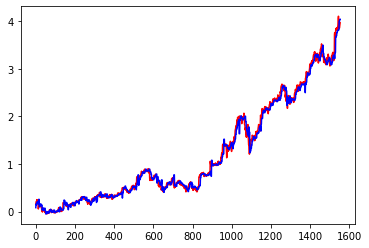

correct red, predict blue


In [17]:
stock_file_name = 'D:/c/testd/amazon/AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
del raw_dataframe['Date'] # 위 줄과 같은 효과
stock_input = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다

#============================ 가격형태 데이터들을 정규화한다=========================================
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_input[:,:-1]
#norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
norm_price = data_standardization(price)

print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_input[:,-1:]
#norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
norm_volume = data_standardization(volume)
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

# 행은 그대로 두고 열을 우측에 붙여 합친다
stock_input = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
#============================================================================================

stock_target = stock_input[:, [-2]] # 타켓은 주식 종가이다
train_size = int(stock_target.shape[0] * 0.7)
correct_v = np.array(stock_target[train_size:len(stock_target)])
"""
fp = open("target_data", 'w')
print("---------------target data print---------------------")
nrow = stock_target.shape[0]
i = 0
while i < nrow:
    data = "%d: %s\n" % (i, stock_target[i, :])
    print(data)
    fp.write(data)
    i = i + 1
fp.close()

fp = open("correct_v", 'w') 
print("---------correct v-----------------")
line = train_size
n = correct_v.shape[0]
i = 0
while i < n:
    data = "%d: %f\n" % (line, correct_v[i])
    print(data)
    fp.write(data)
    i += 1
    line += 1
fp.close()
"""
print("-------------------------------------")
rv = mp.direct(stmt, "execute mempute('perception', 'stock_f3')")

#r = exec_batch2("f", stmt, stock_input, train_size, 5, 3, 1, 0, 1)
r = exec_batch2("f", stmt, stock_input, train_size, 5, 3, 3, 0, 1) #3개 앞 보기
#r = exec_batch2("f", stmt, stock_input, train_size, 5, 3, 6, 0, 1) #3개 앞 보기

row = r.shape[0]
col = r.shape[1]
predict_v = np.empty((row * col, 1))
i = k = 0
while i < row:#출력 시퀀스가 여러개 , 즉 결과 배열이 2차원이므로 이를 1차원으로 변경.
    j = 0
    while j < col:
        predict_v[k, 0] = r[i, j]
        j += 1
        k += 1
    i += 1

predict_v = predict_v[:-3, [0]] #끝에 한개 자름.


#predict_v = reverse_min_max_scaling(price, predict_v) # 금액데이터 역정규화한다
#correct_v = reverse_min_max_scaling(price, correct_v)
#predict_v = reverse_standardization(price, predict_v) # 금액데이터 역정규화한다 
#correct_v = reverse_standardization(price, correct_v)

print("---------correct predict v-----------------")
n = predict_v.shape[0]
i = 0
line = train_size
while i < n:
    data = "%d:%d %f %f\n" % (line, i, correct_v[i], predict_v[i])
    print(data)
    i += 1
    line += 1

#x = np.concatenate((correct_v, predict_v), axis=1)
#with open(sys.argv[3], 'wb') as sdata:
#    pickle.dump(x, sdata)

plt.figure(1)
plt.plot(correct_v, 'r')
plt.plot(predict_v, 'b')
plt.show()

print("correct red, predict blue")

이상 데이터 탐지 ( 금융 사기거래 탐지)

In [29]:
import mempute as mp
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import tensorflow.contrib as tc
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import  sys
import time
from utils import BaseModelMixin, REPO_ROOT
import json
import os
from netshell import NetShell

In [30]:
def convert_row_first(d_type, aarray):
    n_input_row = aarray.shape[0]
    n_input_col = aarray.shape[1]
    output_arr = np.zeros((int(n_input_row), n_input_col), dtype = d_type)
    in_row = 0
    while in_row < n_input_row:
        output_arr[in_row,:] = aarray[in_row,:]
        in_row += 1
    return output_arr

#get_ipython().run_line_magic('matplotlib', 'inline')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

np.set_printoptions(precision=4, suppress=True)

df = pd.read_csv("anormdata/creditcard.csv")

df.isnull().values.any()

from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
#data['Class'] = 1
"""
tot = data.values
minv = np.min(tot)
print(minv)
"""
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

x_train, x_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

small_test = 2
test_predict = 0
signid_num = 5
idpred_print = 0
dense_data = 0
xdisc_adopt = 0

if small_test:
    x_train = x_train.iloc[:3000]#3000 이면 u0.002d, 1000 이면 u0.02d
    x_test = x_test.iloc[:3000]
if idpred_print: 
    x_train = x_train.iloc[:1000]
    x_test = x_test.iloc[:1000]

y_train = x_train['Class']
x_train = x_train.drop(['Class'], axis=1)


y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)


x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values
"""
#데이터를 양수 값을 만들기 위해 최소값을 더해 준다. 안해도 된다.
if sys.argv[1] is not '5':
    x_train = x_train - minv
    x_test = x_test - minv
"""
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(x_train)
print(y_train)

x_train = convert_row_first("f", x_train)
y_train = convert_row_first("f", y_train)#y_train = convert_row_first("i", y_train)
if test_predict:
    x_test = convert_row_first("f", x_test)
    y_test = convert_row_first("f", y_test)#y_test = convert_row_first("i", y_test)
else:
    x_test = x_train
    y_test = y_train
    
def shuffle(x: np.array, y: np.array):
    N = x.shape[0]
    indices = np.random.permutation(np.arange(N))
    x = x[indices]
    if y is not None: y = y[indices]
    return x, y


def anormal_learning():
    rv = mp.array(stmt, "execute mempute('array', 'anormal_input locale array_loc 1 1 1 0 0 0')")
    mp.inarray(stmt, x_train, 1)

    rv = mp.array(stmt, "execute mempute('array', 'anormal_target locale array_loc 0 1 1 0 0 0')")
    mp.inarray(stmt, y_train, 1)

    rv = mp.array(stmt, "execute mempute('array', 'anormal_input')")

    rv = mp.direct(stmt, "execute mempute('load', 'anormal_input', 0, -1)")

    rv = mp.array(stmt, "execute mempute('array', 'anormal_target')")

    rv = mp.direct(stmt, "execute mempute('load', 'anormal_target', 0, -1)")

    rv = mp.direct(stmt, "execute mempute('cognit', 'anormal_input', 'anormal_target')")

    rv = mp.direct(stmt, "execute mempute('oblivion', 0)") #이 스템을 실행하여 루프 안에서 반복되도 된다.


(3000, 29)
(3000, 1)
(3000, 29)
(3000, 1)
[[ 1.955  -0.3808 -0.315  ...  0.0452 -0.0471 -0.3133]
 [-0.401  -0.6269  1.5553 ... -0.3705 -0.1448 -0.1697]
 [ 0.0725  0.8206 -0.5614 ...  0.2064  0.0703 -0.3053]
 ...
 [-1.2209 -0.5411  2.1175 ... -0.0973  0.1001  0.8903]
 [-2.6637  2.3961 -1.7349 ...  0.0432 -0.0517 -0.3502]
 [-0.4123  0.8777 -0.7018 ...  0.1312  0.1118  0.4259]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


금융 사기 거래 데이터 학습

In [33]:


rv = mp.direct(stmt,"execute mempute('clear', 'anormal 0 percep_loc 0 0 all erase 0')")
rv = mp.direct(stmt, "execute mempute('perception', 'anormal locale percep_loc')")
    
#rv = mp.direct(stmt, "execute mempute('sequence', 29, 1, 2)")
#rv = mp.direct(stmt, "execute mempute('sequence', 29, 1, '28')") #시퀀스 룰러 구성이므로 아래 스키마도 
rv = mp.direct(stmt, "execute mempute('sequence', 29, 1, '-1')") #룰러 구성으로 해야 한다.

if small_test:
    #rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.002d}')") #룰러 및 기울기 구성
    rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.0d}')")
else:
    rv = mp.direct(stmt, "execute mempute('channel', 1, '{u0.0001d}')")
#rv = mp.direct(stmt, "execute mempute('channel', 1, '{ld}')") #기울기 구성
rv = mp.direct(stmt, "execute mempute('channel', 0, '{d}')") 

rv = mp.direct(stmt, "execute mempute('phyper', 'sensitivity 2.7')")
    
anormal_learning()


금융 사기 거래 예측

(3000, 29)
(3000, 1)
(3000, 1)
index : 427 proud:proud
index : 838 proud:proud
index : 1174 proud:proud
index : 1433 proud:proud
index : 1477 proud:proud
index : 2553 proud:proud
index : 2586 proud:proud
normal-proud : 0 proud:normal : 0 proud:proud : 7


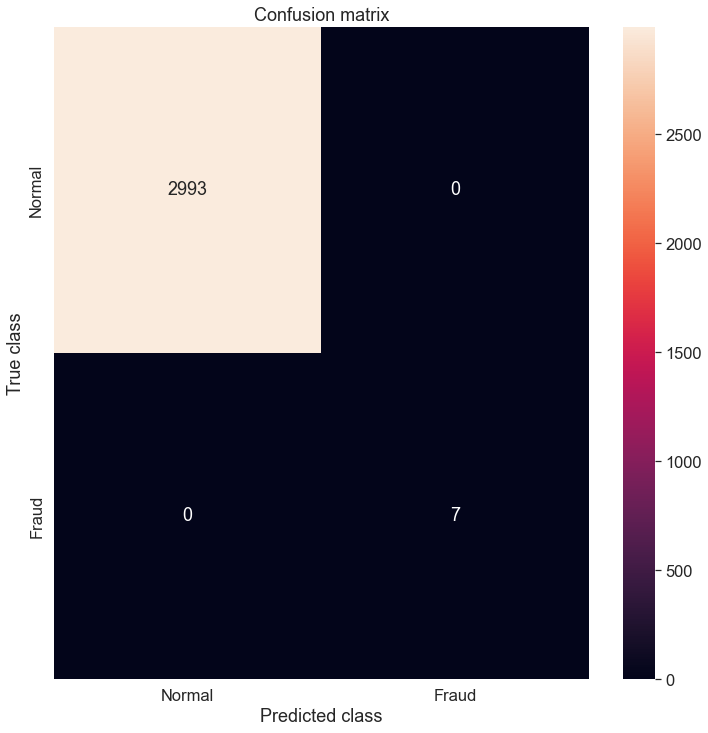

In [34]:

    
rv = mp.direct(stmt, "execute mempute('perception', 'anormal')")

rv = mp.array(stmt, "execute mempute('array', 'eval_input 1 1 0 0 0 0')")

rv = mp.array(stmt, "execute mempute('array', 'eval_output 0 1 0 0 0 0')")

rv = mp.focus(stmt, "execute mempute('array', 'eval_input')")

mp.inarray(stmt, x_test, 1)

predictions = mp.mempute(stmt, "execute mempute('predict', 'eval_input', 'eval_output')")

print(x_test.shape)
print(y_test.shape)
print(predictions.shape)

norm_Proud = proud_norm = proud_proud = 0
prev_v = np.zeros((predictions.shape[0], predictions.shape[1]), dtype = 'i')
for i, (y, p) in enumerate(zip(y_test, predictions)):
    if y == 0:
        if p > 0.5: 
            prev_v[i] = 1
            norm_Proud += 1
            print("index : {} normal:proud".format(i))
    else:
        if p > 0.5: 
            prev_v[i] = 1
            proud_proud += 1
            print("index : {} proud:proud".format(i))
        else:
            proud_norm += 1
            print("index : {} proud:normal".format(i))

print("normal-proud : {} proud:normal : {} proud:proud : {}".format(norm_Proud, proud_norm, proud_proud))

#predictions = predictions.astype('int32')
predictions = prev_v

#for i, v in enumerate(predictions):
#    if v > 0.5: predictions[i] = 1
#    else: predictions[i] = 0
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()